# Image Captioning on the MS COCO Dataset using Autoencoders

**The Image Captioning is carried out on the ARMBench Dataset here using Autoencoders and Nearest Neighbours**

The necessary libraries are imported

In [1]:
import pandas as pd #Import necessary libraries
import numpy as np
import json
import cv2
import string
import nltk
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from keras.models import Model
from keras.losses import mean_squared_error
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
from sklearn.utils import resample
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

C:\Users\sahre\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [4]:
BASE_PATH = 'D:/Down/cocodataset' # Set the base path to the location where the dataset is present

## Data Preprocessing

Here, the first 50000 images are used and image paths are added to the dataframe. 

In [5]:
with open(f'{BASE_PATH}/annotations_trainval2017/annotations/captions_train2017.json', 'r') as f: #load annotations
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_id = sample['image_id']
    img_name = '%012d.jpg' % img_id
    img_cap_pairs.append([img_id, img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['id', 'image', 'caption']) #create df with the images, ids and captions
captions['image'] = captions['image'].apply(lambda x: f'{BASE_PATH}/train2017/train2017/{x}')

captions = captions.sample(50000)
captions = captions.reset_index(drop=True)
captions.rename(columns={'id': 'image_id'}, inplace=True)
print(captions.head())

   image_id                                              image  \
0    531189  D:/Down/cocodataset/train2017/train2017/000000...   
1    447075  D:/Down/cocodataset/train2017/train2017/000000...   
2    275997  D:/Down/cocodataset/train2017/train2017/000000...   
3    228671  D:/Down/cocodataset/train2017/train2017/000000...   
4     49143  D:/Down/cocodataset/train2017/train2017/000000...   

                                             caption  
0  a red fire hydrant and a small dog out on the ...  
1    Several people are climbing on a white object.   
2    This is a cluttered but well organized bedroom.  
3      a woman is holding a tennis racket in a court  
4  A man kneels down next to a suitcase full of b...  


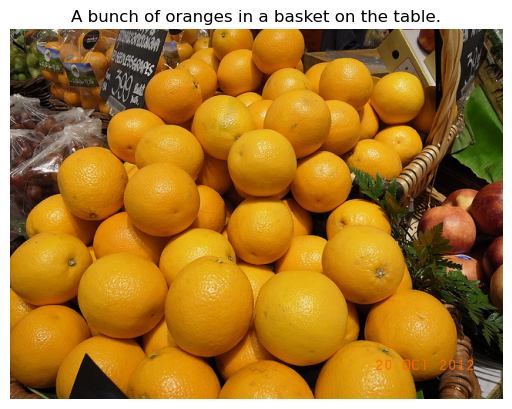

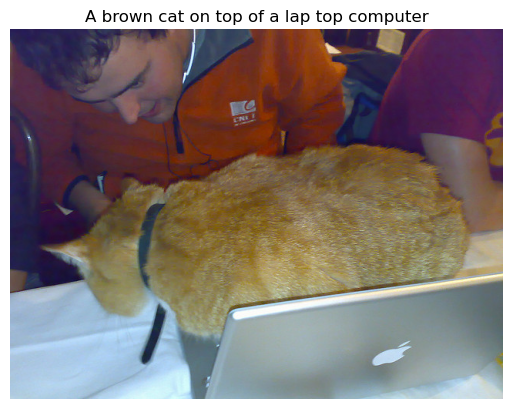

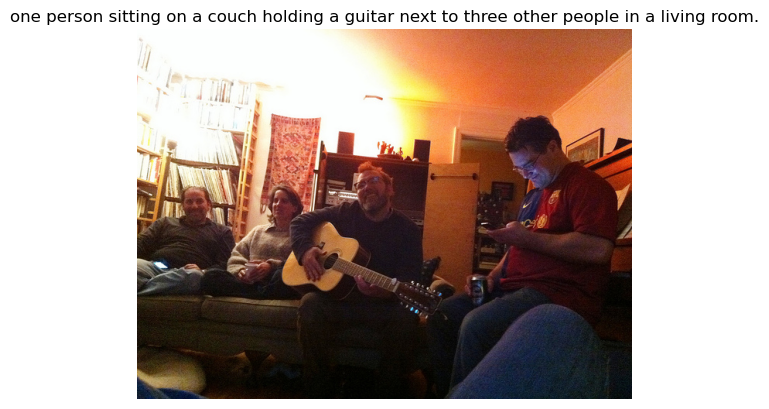

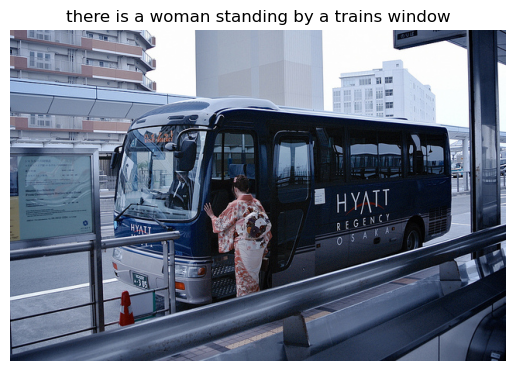

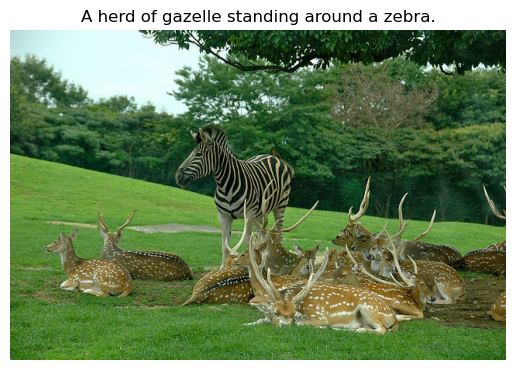

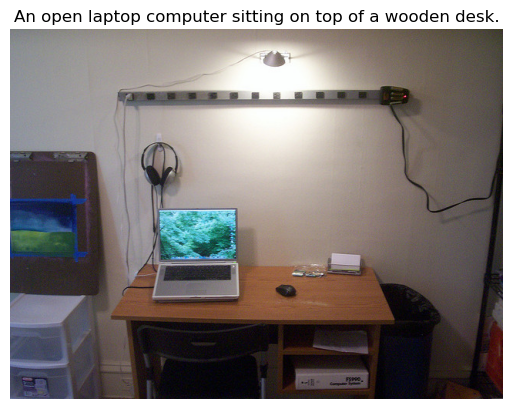

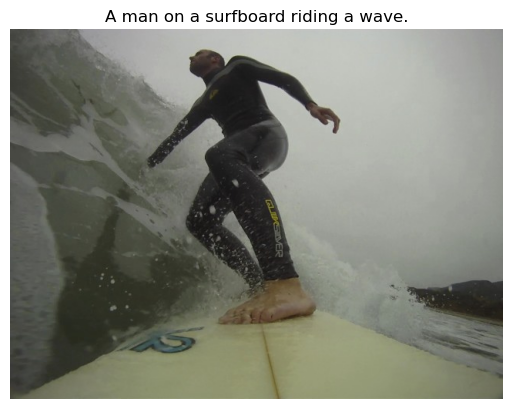

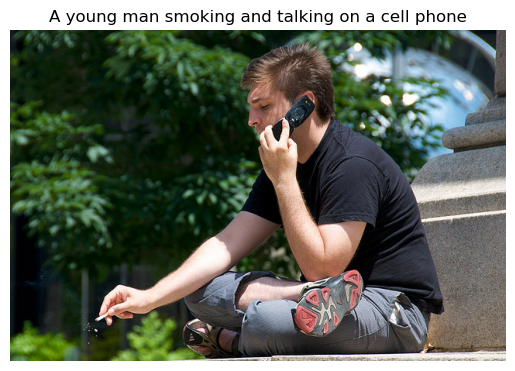

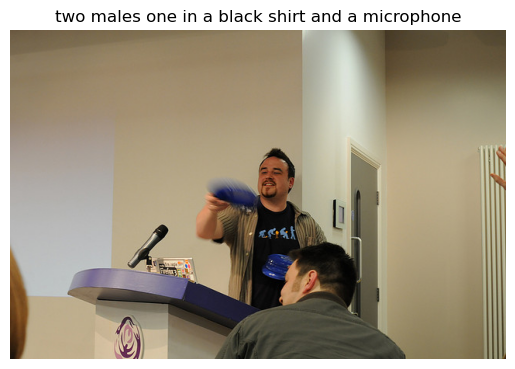

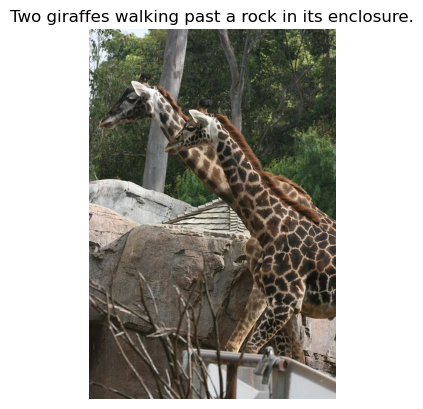

In [6]:
def display_image_with_caption(image_path, caption): #visualise some images and their captions
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

for i in range(10):
    index = captions.sample().index[0]
    image_path = captions.loc[index, 'image']
    caption = captions.loc[index, 'caption']
    display_image_with_caption(image_path, caption)


In [7]:

with open('D:/Down/cocodataset/annotations_trainval2017/annotations/instances_train2017.json', 'r') as file:
    data = json.load(file)

In [8]:

with open(f'{BASE_PATH}/annotations_trainval2017/annotations/instances_train2017.json', 'r') as f:
    data = json.load(f)

data['categories'] = list(data['categories']) #data cleaning
category_dict = {category['id']: {'name': category['name'], 'supercategory': category['supercategory']} for category in data['categories']}
data_list = []
for item_id, item_info in enumerate(data['annotations']):
    item_dict = {
        'image_id': item_info['image_id'],
        'category_id': item_info['category_id'],
        'id': item_info['id'],
        'name': category_dict[item_info['category_id']]['name'],  
        'supercategory': category_dict[item_info['category_id']]['supercategory']  
    }
    data_list.append(item_dict)

df = pd.DataFrame(data_list)

In [9]:
merged_df = captions.merge(df, on='image_id', how='inner')

In [10]:
import pandas as pd

unique_categories = merged_df['name'].unique() #unique supercategories


print("Unique Categories in the 'name' column:")
print(unique_categories)


Unique Categories in the 'name' column:
['dog' 'fire hydrant' 'bus' 'person' 'suitcase' 'backpack' 'tv' 'bed'
 'book' 'handbag' 'teddy bear' 'sports ball' 'tennis racket' 'tie'
 'traffic light' 'kite' 'cell phone' 'bottle' 'microwave' 'oven' 'sink'
 'cup' 'refrigerator' 'bowl' 'broccoli' 'carrot' 'cow' 'chair'
 'dining table' 'wine glass' 'spoon' 'fork' 'knife' 'vase' 'potted plant'
 'car' 'train' 'couch' 'laptop' 'remote' 'clock' 'sheep' 'baseball bat'
 'baseball glove' 'bicycle' 'apple' 'cat' 'frisbee' 'cake' 'umbrella'
 'stop sign' 'giraffe' 'sandwich' 'pizza' 'skis' 'toaster' 'skateboard'
 'banana' 'horse' 'orange' 'toilet' 'donut' 'bench' 'airplane' 'surfboard'
 'keyboard' 'mouse' 'zebra' 'parking meter' 'bird' 'truck' 'toothbrush'
 'elephant' 'scissors' 'bear' 'motorcycle' 'snowboard' 'boat' 'hot dog'
 'hair drier']


The Supercategory Counts are printed for the Top 10 Most Frequently Occurring categories.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
merged_df = merged_df.drop_duplicates(subset=['caption'])

category_freq = merged_df['supercategory'].value_counts() #Dominant Supercategory Counts


top_10_categories = category_freq.nlargest(10).index.tolist()

print(category_freq[top_10_categories])


supercategory
person        9228
animal        8880
vehicle       8144
furniture     5287
kitchen       3542
electronic    2617
sports        2379
food          2346
indoor        2138
accessory     2085
Name: count, dtype: int64


2000 Samples are selected from all 10 categories and category distibution is plotted on a bar chart.

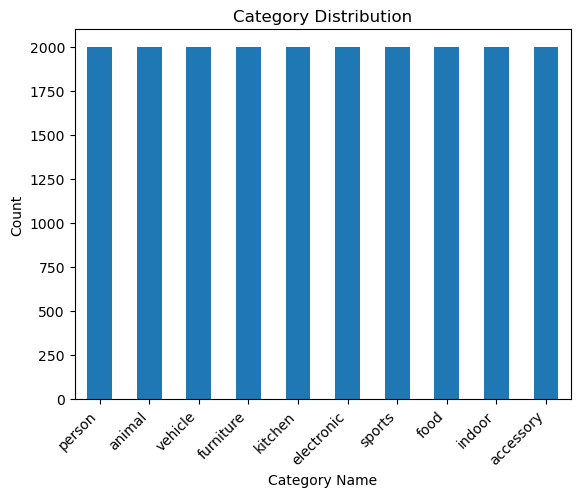

In [12]:

df = pd.DataFrame()

for supercategory in top_10_categories:
    category_data = merged_df[merged_df['supercategory'] == supercategory].head(2000)
    df = pd.concat([df, category_data])

df.reset_index(drop=True, inplace=True)

category_counts = df['supercategory'].value_counts() #Plotting the value counts


category_counts.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.show()

In [13]:

df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)


In [14]:

def preprocess_image(image_path, target_size=(64, 64)): #Data preprocessing
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise Exception(f"Failed to read the image at path: {image_path}")

        if len(img.shape) == 2:
            img = gray2rgb(img)
        img_resized = resize(img, target_size, mode='reflect')
        return img_resized
    except Exception as e:
        print(f"Error processing image: {e}")
        return None


In [15]:
def preprocess_caption(caption): #Caption preprocessing
    # Lowercase
    caption = caption.lower()
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    words = caption.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [16]:
from sklearn.model_selection import train_test_split

df_train_temp, df_temp = train_test_split(df, test_size=0.2, random_state=42) #Data splitting

df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
df_test2 = df_test.copy()
df_validation2 = df_validation.copy()

def preprocess_data(df):
    df['image'] = df['image'].apply(preprocess_image)
    df['caption_preprocessed'] = df['caption'].apply(preprocess_caption)
    df = df.dropna(subset=['image'])
    return np.array(df['image'].tolist()), df

x_train, df_train = preprocess_data(df_train_temp)
x_validation, df_validation = preprocess_data(df_validation)
x_test, df_test = preprocess_data(df_test)


## Autoencoder

The autoencoder architecture (encoder and decoder) is defined and run for 100 epochs with a batch size of 128

In [17]:
input_img = Input(shape=(64, 64, 3))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #encoder architecture
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) #decoder architecture
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, shuffle=True, validation_data=(x_test, x_test)) #training the model

Epoch 1/100
125/125 [==============================] - 37s 289ms/step - loss: 0.6055 - val_loss: 0.5709
Epoch 2/100
125/125 [==============================] - 35s 284ms/step - loss: 0.5589 - val_loss: 0.5531
Epoch 3/100
125/125 [==============================] - 35s 284ms/step - loss: 0.5488 - val_loss: 0.5491
Epoch 4/100
125/125 [==============================] - 36s 287ms/step - loss: 0.5461 - val_loss: 0.5472
Epoch 5/100
125/125 [==============================] - 35s 283ms/step - loss: 0.5446 - val_loss: 0.5459
Epoch 6/100
125/125 [==============================] - 36s 286ms/step - loss: 0.5435 - val_loss: 0.5452
Epoch 7/100
125/125 [==============================] - 36s 285ms/step - loss: 0.5426 - val_loss: 0.5443
Epoch 8/100
125/125 [==============================] - 36s 285ms/step - loss: 0.5419 - val_loss: 0.5435
Epoch 9/100
125/125 [==============================] - 36s 287ms/step - loss: 0.5411 - val_loss: 0.5427
Epoch 10/100
125/125 [==============================] - 36s 288m

125/125 [==============================] - 36s 286ms/step - loss: 0.5348 - val_loss: 0.5371
Epoch 80/100
125/125 [==============================] - 36s 285ms/step - loss: 0.5348 - val_loss: 0.5369
Epoch 81/100
125/125 [==============================] - 36s 286ms/step - loss: 0.5348 - val_loss: 0.5368
Epoch 82/100
125/125 [==============================] - 36s 287ms/step - loss: 0.5347 - val_loss: 0.5371
Epoch 83/100
125/125 [==============================] - 36s 288ms/step - loss: 0.5347 - val_loss: 0.5370
Epoch 84/100
125/125 [==============================] - 35s 284ms/step - loss: 0.5347 - val_loss: 0.5370
Epoch 85/100
125/125 [==============================] - 36s 287ms/step - loss: 0.5347 - val_loss: 0.5368
Epoch 86/100
125/125 [==============================] - 36s 284ms/step - loss: 0.5347 - val_loss: 0.5368
Epoch 87/100
125/125 [==============================] - 36s 287ms/step - loss: 0.5347 - val_loss: 0.5367
Epoch 88/100
125/125 [==============================] - 36s 284ms/st

In [19]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_1').output)
x_train_encoded = encoder.predict(x_train) #encoded images
x_test_encoded = encoder.predict(x_test)

63/63 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 59ms/step


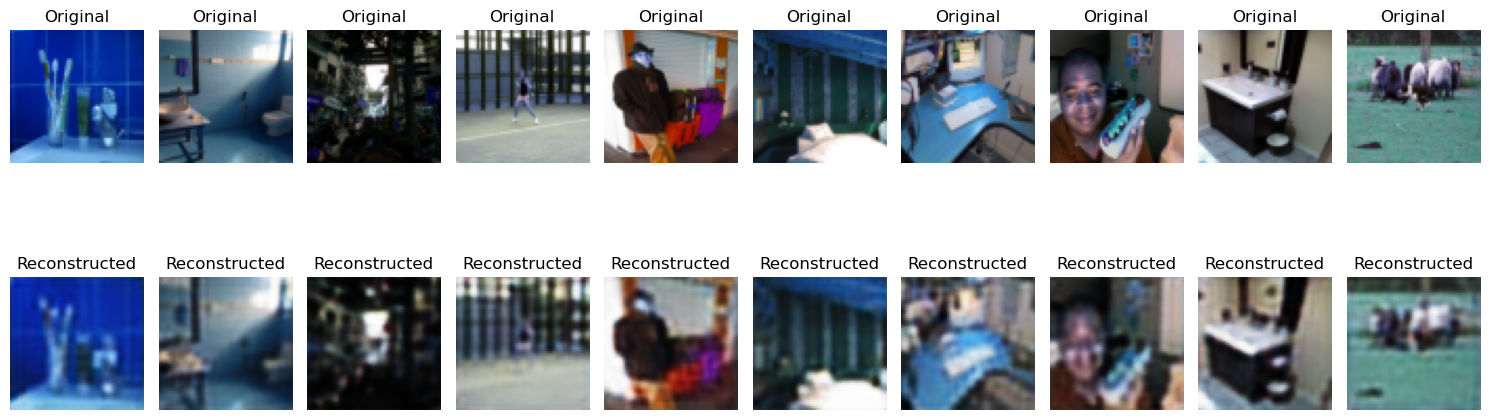

In [20]:
#visualising the original and reconstructed images
import numpy as np
num_images_to_visualize = 10
random_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
images_to_visualize = x_test[random_indices]

reconstructed_images = autoencoder.predict(images_to_visualize)


plt.figure(figsize=(15, 6))
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(images_to_visualize[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, num_images_to_visualize + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

The Reconstruction Loss is calculated using the Mean Squared Error Loss.

In [50]:

reconstructed_images = autoencoder.predict(x_test)

# Calculate the Mean Squared Error (MSE) loss
mse_loss = mean_squared_error(x_test, reconstructed_images)

average_mse_loss = np.mean(mse_loss)
print("Average MSE Loss:", average_mse_loss)

63/63 [==============================] - 1s 20ms/step
Average MSE Loss: 0.00367137


## Nearest Neighbours

The encoded images are flattened and fitted in the Nearest Neighbor Model.

In [51]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1) #fitting the encoded images to Nearest Neighbours

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(x_train_flat)


Here, a random image is visualised and the true and nearest neighbour caption is printed.

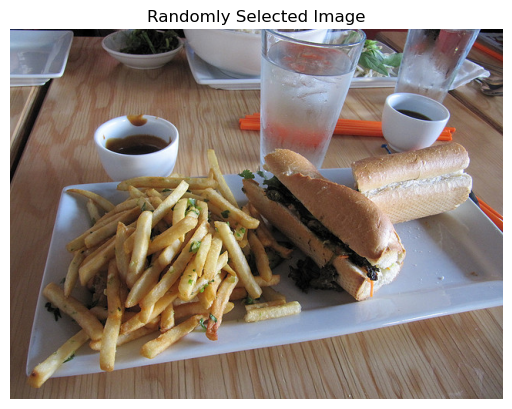

True caption for the randomly selected image: Picture of a plate with fries and cut sub on it.
Generated caption for the randomly selected image: a plate full of fries and a sandwich cut in half


In [58]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image") #visualising a random image
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0]  # Predicting the caption of the closest neighbor of the image


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")


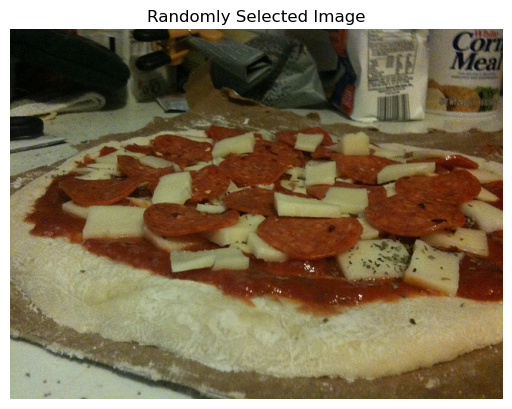

True caption for the randomly selected image: An uncooked pizza has chunks of cheese and pepperoni.
Generated caption for the randomly selected image: A raw pizza prepared with pepperoni, cheese and sauce.


In [60]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

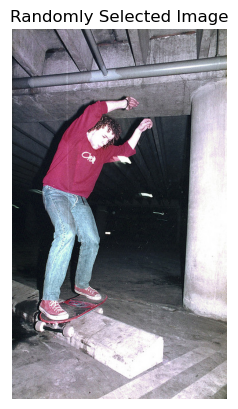

True caption for the randomly selected image: A man that is on a curb with a skateboard.
Generated caption for the randomly selected image: a man stands on a skateboard while balancing on a block


In [64]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

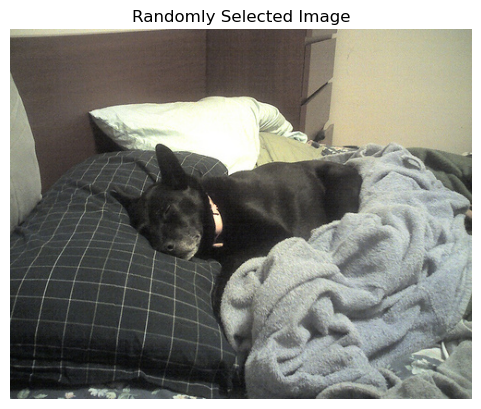

True caption for the randomly selected image: A dog sleeping on a pillow in a bed.
Generated caption for the randomly selected image: A woman standing on a tennis court holding a racquet.


In [63]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

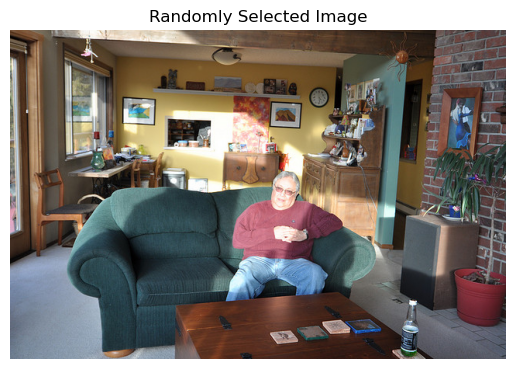

True caption for the randomly selected image: A man that is sitting on a couch.
Generated caption for the randomly selected image: Several sheep in a grassy field near a crow in flight.


In [62]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

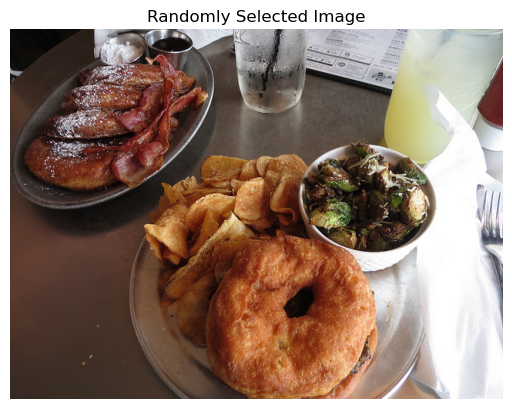

True caption for the randomly selected image: junk food  placed in plates and ready to be eaten
Generated caption for the randomly selected image: A pair of scissors sitting on top of the floor.


In [61]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

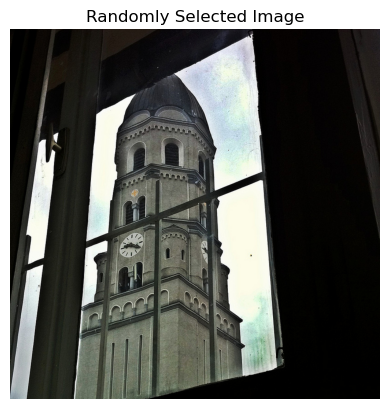

True caption for the randomly selected image: View of a clock tower through a window.
Generated caption for the randomly selected image: Looking out a window at a tall building with a clock on the face.


In [65]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

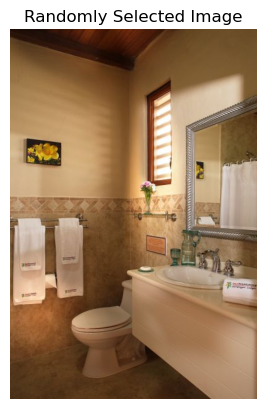

True caption for the randomly selected image: The set of monogrammed towels is hanging by the toilet.
Generated caption for the randomly selected image: A sleek computer keyboard and mouse on a desktop.


In [66]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

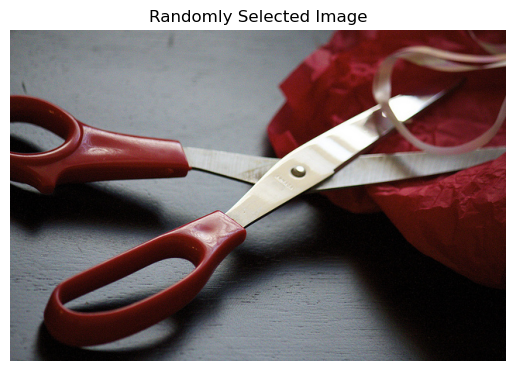

True caption for the randomly selected image: A pair of scissors, red tissues and a pink ribbon.
Generated caption for the randomly selected image: A white western toilet with no seat cover.


In [67]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

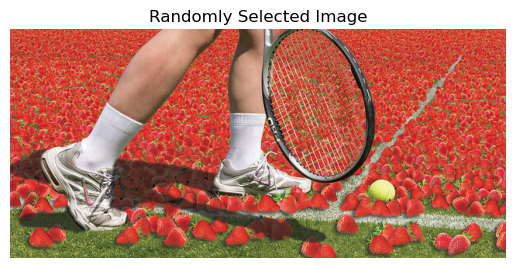

True caption for the randomly selected image: A person playing tennis stands surrounded by strawberries.
Generated caption for the randomly selected image: A grass umbrella planted in sand marked by vehicle tracks.


In [68]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

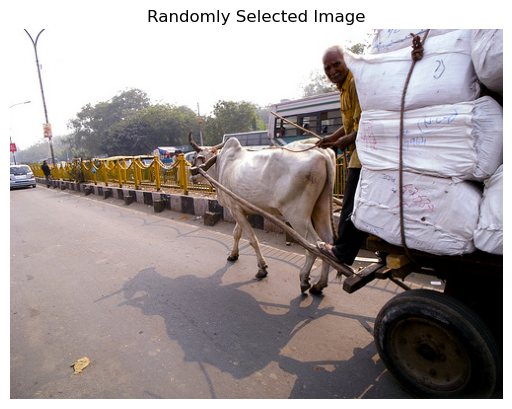

True caption for the randomly selected image: a cow pulling a lot of cargo with a person on the cargo
Generated caption for the randomly selected image: Two men in hard hats are by their computers.


In [69]:


random_index = np.random.randint(0, len(df_test))

image_path = df_test2.iloc[random_index]['image']

random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)

neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Test Set.

In [70]:
#test set
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_test):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['caption'].values
    true_caption = df_test.iloc[i]['caption']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_test)
average_meteor_score_average = total_meteor_score_average / len(x_test)
average_meteor_score_median = total_meteor_score_median / len(x_test)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.17992388490930772
Average METEOR Score using Average Distance: 0.12494904968925488
Average METEOR Score using Median Distance: 0.1258230294473529


Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set.

In [71]:
#validation set
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['caption'].values
    true_caption = df_validation.iloc[i]['caption']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.17796268795539452
Average METEOR Score using Average Distance: 0.1260240457172002
Average METEOR Score using Median Distance: 0.12622781181928697


## Hyperparameter Tuning

Hyperparameter Tuning is carried out to choose the most optimal distance metric.

In [74]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [75]:
from sklearn.metrics import pairwise_distances


metrics_to_test = ['minkowski', 'manhattan', 'euclidean', 'cosine'] #distance metrics to test


n_neighbors_fixed = 5

best_score = float('inf')
best_metric = None


for metric in metrics_to_test:
    neighbors = NearestNeighbors(n_neighbors=n_neighbors_fixed, metric=metric)
    neighbors.fit(x_train_flat)
    
    distances, _ = neighbors.kneighbors(x_train_flat, n_neighbors=1)
    mean_distance = distances.mean()
    
    if mean_distance < best_score:
        best_score = mean_distance
        best_metric = metric

print("Best metric:", best_metric)


Best metric: manhattan


The encoded images are fitted again using the manhattan distance as the distance metric.

In [77]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1)

neighbors = NearestNeighbors(n_neighbors=5, metric = "manhattan") #fitting the model with the best distance metric
neighbors.fit(x_train_flat)


Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set with Manhattan Distance as the Distance Metric.

In [80]:
#validation set
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['caption'].values
    true_caption = df_validation.iloc[i]['caption']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.1789027555740764
Average METEOR Score using Average Distance: 0.12684883236406735
Average METEOR Score using Median Distance: 0.12503692825527743
